In [1]:
import pandas as pd
import numpy as np
import alphalens as al
import pymysql

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False


from scipy.stats.mstats import winsorize


from sklearn.linear_model import LinearRegression

import statsmodels.formula.api as sm



In [5]:
# 获取因子相关数据

conn=pymysql.connect(host='10.3.71.120',database='quant',user='root',password='stark12345+',port=3306)
sql='select ts_code,trade_date,close,turnover_rate,total_share from stock_basic'
data_use=pd.read_sql(sql,conn)


In [3]:
##获取行业代码数据

conn=pymysql.connect(host='10.3.71.120',database='quant',user='root',password='stark12345+',port=3306)
sql='select ts_code,trade_date,industry_id from stock_industry'
industry_sheet=pd.read_sql(sql,conn)


# 获取行业ID与行业名称

conn=pymysql.connect(host='10.3.71.120',database='quant',user='root',password='stark12345+',port=3306)
sql='select industry_id,industry_name from sw_industry'
industry_name_sheet=pd.read_sql(sql,conn)

In [7]:
data_use=data_use.set_index(["trade_date","ts_code"]).reset_index()
data_use=data_use.sort_values(by=['ts_code','trade_date'])
data_use["trade_date"] = pd.to_datetime(data_use["trade_date"])

industry_use=industry_sheet.set_index(["trade_date","ts_code"]).reset_index()
industry_use=industry_use.sort_values(by=['ts_code','trade_date'])
industry_use["trade_date"] = pd.to_datetime(industry_use["trade_date"])

industry_use_1=pd.merge(industry_use,industry_name_sheet,on=['industry_id'],how='left')

In [10]:
high_table=data_use[['ts_code','trade_date','close']]
high_table_1=high_table.set_index(["trade_date","ts_code"])
high_table_2=high_table_1.unstack()
high_table_3=high_table_2.rolling(252).max()
high_table_4=high_table_3.stack().reset_index()
high_table_4=high_table_4.rename(columns={'close':'high_252d'})
high_table_4=high_table_4.sort_values(by=['ts_code','trade_date'])
high_table_4=high_table_4.set_index(["ts_code","trade_date"]).reset_index()


merge_1=pd.merge(high_table_4,data_use,on=['trade_date','ts_code'])
merge_1["high52"]=(merge_1["close"]/merge_1["high_252d"])
merge_1=merge_1.sort_values(by=['ts_code','trade_date']).set_index(["ts_code","trade_date"]).reset_index()


In [13]:


industry_use_1=pd.merge(industry_use,industry_name_sheet,on=['industry_id'],how='left')

industry_factor=pd.merge(industry_use_1,merge_1,on=['ts_code','trade_date'],how='inner')
industry_factor_1=industry_factor[industry_factor['trade_date']=='2020-12-31']
industry_factor_2=industry_factor_1.groupby(['industry_name'])['high52'].mean()
industry_factor_2=pd.DataFrame(industry_factor_2)
industry_factor_2=industry_factor_2.reset_index()

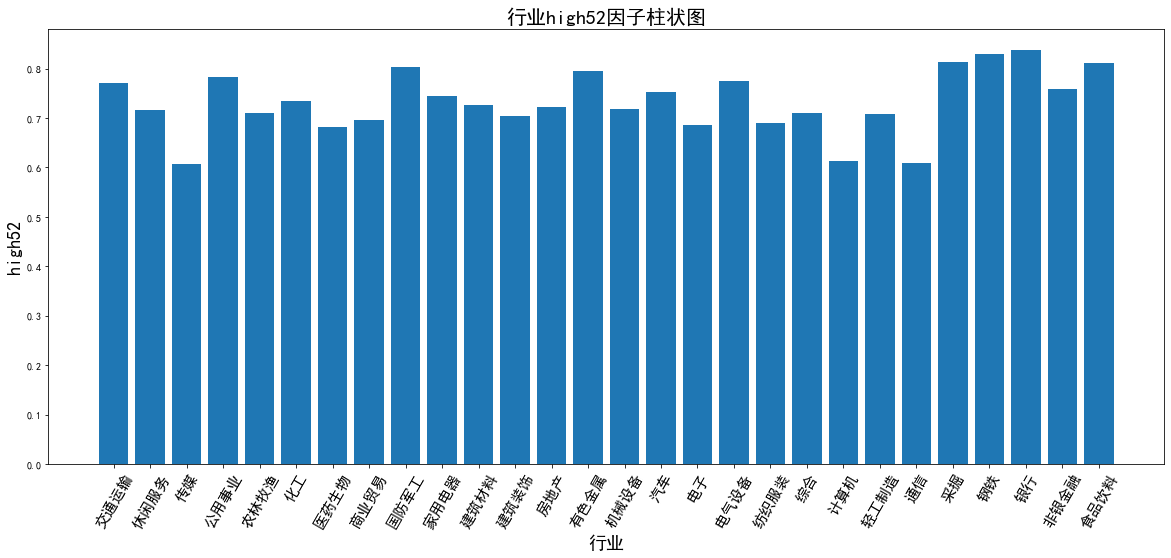

<Figure size 432x288 with 0 Axes>

In [15]:
####行业high52因子柱状图 (数据采纳2020.12.31各行业均值)

plt.figure(figsize=(20,8))
x=industry_factor_2['industry_name']
y=industry_factor_2['high52']
plt.bar(x,y)
plt.title('行业high52因子柱状图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(0,6,1)
plt.xlabel('行业',fontsize=18)
plt.ylabel('high52',fontsize=18)
# plt.grid()
plt.show()
plt.savefig('行业high52因子柱状图.png')

In [16]:
# 行业因子排名表格，数据：2015-2020年最后一个交易日数据行业均值

industry_rank=industry_factor[(industry_factor['trade_date']=='2020-12-31')|(industry_factor['trade_date']=='2019-12-31')|(industry_factor['trade_date']=='2018-12-28')|(industry_factor['trade_date']=='2017-12-29')|(industry_factor['trade_date']=='2016-12-30')|(industry_factor['trade_date']=='2015-12-31')]
industry_rank_1=industry_rank.groupby(['trade_date','industry_name'])['high52'].mean()
industry_rank_2=pd.DataFrame(industry_rank_1).reset_index()
industry_rank_2['年份']=industry_rank_2['trade_date'].dt.year
industry_rank_2=industry_rank_2.rename(columns={'industry_name':'行业'})
industry_rank_2['rank']=industry_rank_2.groupby(['年份'])['high52'].rank(ascending=False)
industry_rank_3=industry_rank_2.set_index(['行业','年份'])['rank'].unstack()
file='行业high52因子排名.xlsx'
industry_rank_3.to_excel(file)

In [17]:
industry_rank_3

年份,2015,2016,2017,2018,2019,2020
行业,,,,,,
交通运输,12.0,13.0,4.0,8.0,10.0,9.0
休闲服务,3.0,5.0,5.0,6.0,12.0,17.0
传媒,19.0,27.0,23.0,20.0,23.0,28.0
公用事业,17.0,18.0,9.0,2.0,15.0,7.0
农林牧渔,16.0,21.0,15.0,10.0,26.0,18.0
化工,18.0,16.0,21.0,16.0,20.0,13.0
医药生物,6.0,25.0,10.0,22.0,6.0,25.0
商业贸易,9.0,3.0,18.0,11.0,11.0,22.0
国防军工,23.0,19.0,24.0,17.0,13.0,5.0


In [18]:
# 因子按市值分层：1-5递增  数据为2015-2020年最后一个交易日数据

industry_factor['firm_size']=industry_factor['total_share']*industry_factor['close']
firm_size_group=industry_factor[(industry_factor['trade_date']=='2020-12-31')|(industry_factor['trade_date']=='2019-12-31')|(industry_factor['trade_date']=='2018-12-28')|(industry_factor['trade_date']=='2017-12-29')|(industry_factor['trade_date']=='2016-12-30')|(industry_factor['trade_date']=='2015-12-31')]
firm_size_group['Group_ID']=firm_size_group.groupby(['trade_date'])['firm_size'].transform(lambda x:pd.qcut(x,[0,0.2,0.4,0.6,0.8,1],labels=['1','2','3','4','5']))
firm_size_group_1=pd.DataFrame(firm_size_group.groupby(['trade_date','Group_ID'])['high52'].mean()).reset_index()
firm_size_group_1['year']=firm_size_group_1['trade_date'].dt.year

<ipython-input-18-6af5be5c0212>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  firm_size_group['Group_ID']=firm_size_group.groupby(['trade_date'])['firm_size'].transform(lambda x:pd.qcut(x,[0,0.2,0.4,0.6,0.8,1],labels=['1','2','3','4','5']))


In [21]:
firm_size_group_1[firm_size_group_1['Group_ID']=='1'].high52

0     0.637216
5     0.710282
10    0.508758
15    0.525135
20    0.689611
25    0.663316
Name: high52, dtype: float64

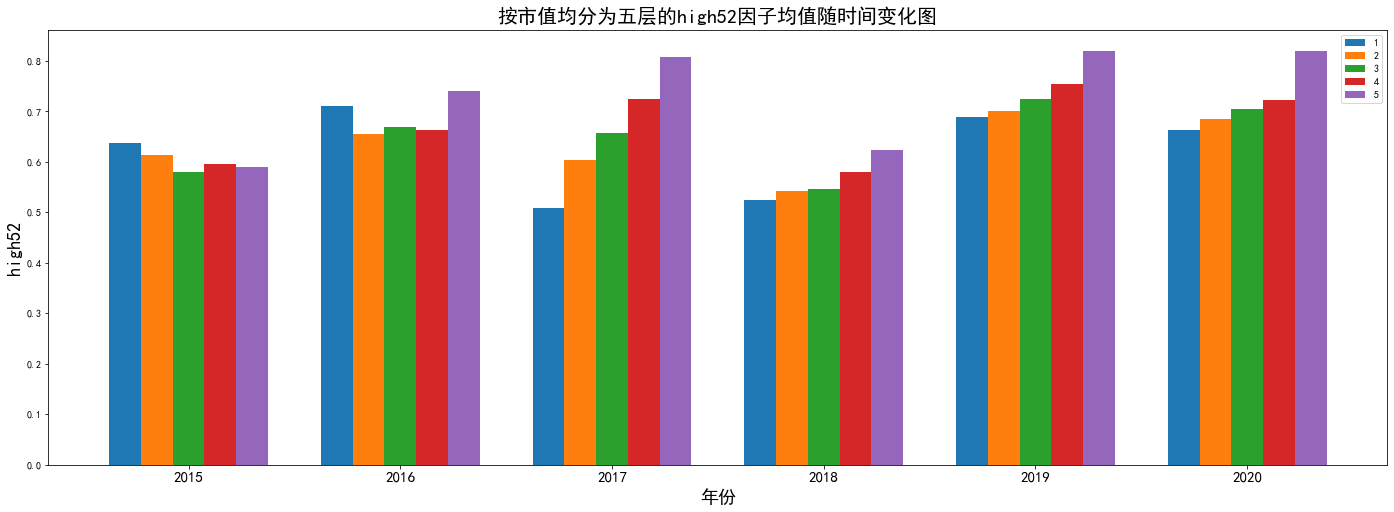

<Figure size 432x288 with 0 Axes>

In [23]:
# 按市值均分为五层的因子均值随时间变化图 数据为2015-2020年最后一个交易日数据

x=pd.Series(np.unique(firm_size_group_1['year']))
labels=['2015','2016','2017','2018','2019','2020']
y1=firm_size_group_1[firm_size_group_1['Group_ID']=='1'].high52
y2=firm_size_group_1[firm_size_group_1['Group_ID']=='2'].high52
y3=firm_size_group_1[firm_size_group_1['Group_ID']=='3'].high52
y4=firm_size_group_1[firm_size_group_1['Group_ID']=='4'].high52
y5=firm_size_group_1[firm_size_group_1['Group_ID']=='5'].high52

width=0.15
pos=np.arange(len(x))

plt.figure(figsize=(24,8))
plt.bar(pos-2*width,y1,width,label='1')
plt.bar(pos-1*width,y2,width,label='2')
plt.bar(pos,y3,width,label='3')
plt.bar(pos+1*width,y4,width,label='4')
plt.bar(pos+2*width,y5,width,label='5')
# plt.grid()
plt.legend() # 图例
plt.title('按市值均分为五层的high52因子均值随时间变化图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
plt.xticks(pos,labels=labels,fontsize=15)
# plt.yticks(y,fontsize=15)
# # plt.ylim(0,6,1)
plt.xlabel('年份',fontsize=18)
plt.ylabel('high52',fontsize=18)

plt.show()
plt.savefig('按市值均分为五层的high52因子均值随时间变化图.png')

In [24]:
# 因子与市值的相关系数变化:不分股票，一年所有数据进行corr计算 2015-2020

industry_factor['year']=industry_factor['trade_date'].dt.year
corr=industry_factor[(industry_factor['trade_date']>'2014-12-31')&(industry_factor['trade_date']<'2021-01-01')]
corr_1=pd.DataFrame(corr.groupby(['year'])['high52'].corr(corr['firm_size'])).reset_index()
corr_1=corr_1.rename(columns={'high52':'corr'})

# 因子与市值的相关系数变化:不分股票，一个交易日所有数据进行corr计算
corr_2=pd.DataFrame(corr.groupby(['trade_date'])['high52'].corr(corr['firm_size'])).reset_index()
corr_2=corr_2.rename(columns={'high52':'corr'})

In [25]:
corr_1

,year,corr
0,2015,0.045410
1,2016,0.089595
2,2017,0.189657
3,2018,0.175994
4,2019,0.132788
5,2020,0.111336


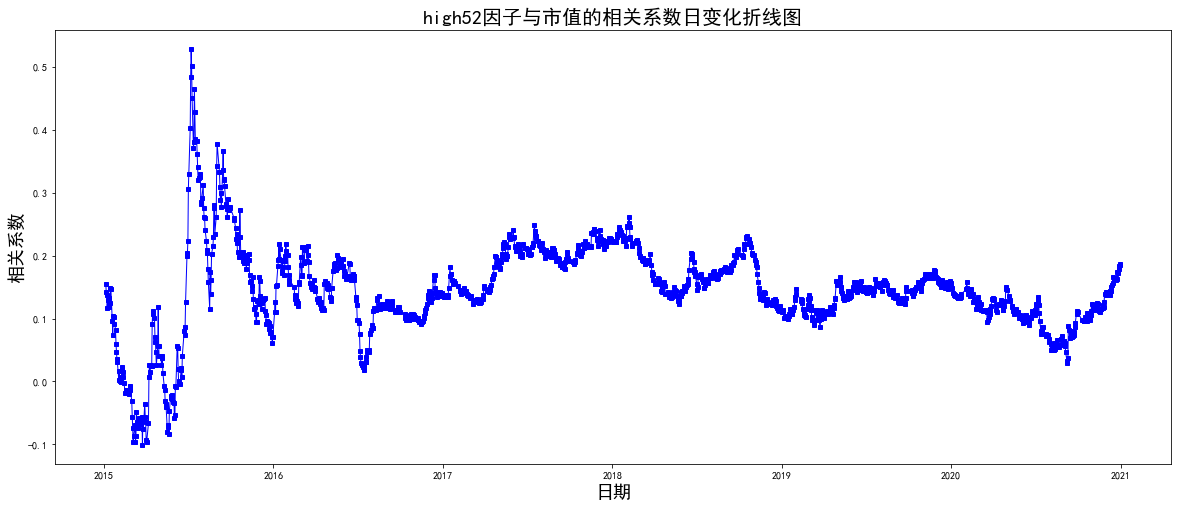

<Figure size 432x288 with 0 Axes>

In [27]:
####因子与市值的相关系数日变化折线图  2015-2020

plt.figure(figsize=(20,8))
x=corr_2['trade_date']
y=corr_2['corr']
plt.plot(x,y,lw=1,c='blue',marker='s',ms=4,label='high52因子与市值的日相关系数')
plt.title('high52因子与市值的相关系数日变化折线图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(-0.15,0.05,0.05)
plt.xlabel('日期',fontsize=18)
plt.ylabel('相关系数',fontsize=18)
# plt.grid()
plt.show()
plt.savefig('high52因子与市值的相关系数日变化折线图.png')

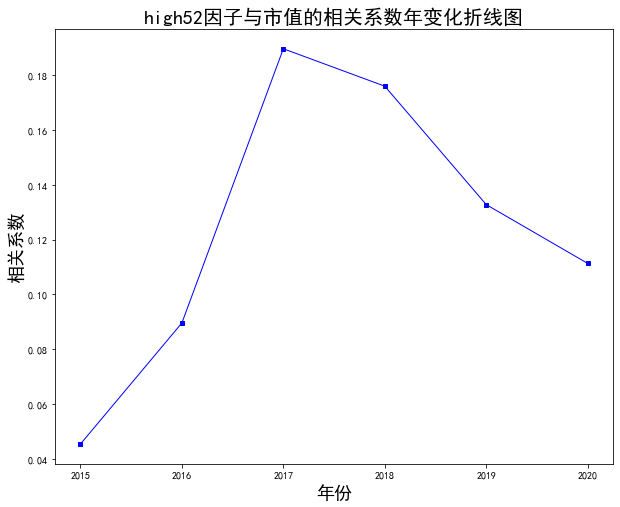

<Figure size 432x288 with 0 Axes>

In [32]:
####因子与市值的相关系数年变化折线图  2015-2020

plt.figure(figsize=(10,8))
x=corr_1['year']
y=corr_1['corr']
plt.plot(x,y,lw=1,c='blue',marker='s',ms=4,label='high52因子与市值的年相关系数')
plt.title('high52因子与市值的相关系数年变化折线图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(-0.1,-0.02,0.005)
plt.xlabel('年份',fontsize=18)
plt.ylabel('相关系数',fontsize=18)
# plt.grid()
plt.show()
plt.savefig('high52因子与市值的相关系数年变化折线图.png')

In [34]:
# 因子处理：去极值处理(winsorize, 0.03)以及中性化处理:先进行行业中性化(减行业均值)后在进行市值中性化（回归取残差），最后做标准化()

industry_factor=industry_factor[(industry_factor['trade_date']>'2014-12-31')&(industry_factor['trade_date']<'2021-01-01')]
industry_factor['win_high52']=winsorize(industry_factor.high52,limits=[0.03,0.03]) # 去极值处理(winsorize,0.03)

In [35]:
# 行业中性化（减行业均值）

neu_ind_1=pd.DataFrame(industry_factor.groupby(['trade_date','industry_name'])['win_high52'].mean())
neu_ind_1=neu_ind_1.rename(columns={'win_high52':'ind_mean'}).reset_index()
neu_ind_2=pd.merge(neu_ind_1,industry_factor,on=['trade_date','industry_name'],how='right')
neu_ind_2['ind_neu_win_high52']=neu_ind_2['win_high52']-neu_ind_2['ind_mean']

In [37]:
# neu_ind_2=neu_ind_2.sort_values(by=['trade_date','industry_name']).drop(columns=['win_turnover'])

In [38]:
neu_ind_2

,trade_date,industry_name,ind_mean,ts_code,industry_id,high_252d,close,turnover_rate,total_share,high52,firm_size,year,win_high52,ind_neu_win_high52
15108,2015-01-05,交通运输,0.901194,000022.SZ,011014,24.41,21.83,2.4565,64476.3730,0.894306,1.407519e+06,2015,0.894306,-0.006889
43291,2015-01-05,交通运输,0.901194,000088.SZ,011014,12.16,10.07,2.2797,194220.0000,0.828125,1.955795e+06,2015,0.828125,-0.073069
44656,2015-01-05,交通运输,0.901194,000089.SZ,011014,6.78,6.00,3.1869,169178.7662,0.884956,1.015073e+06,2015,0.884956,-0.016238
48154,2015-01-05,交通运输,0.901194,000099.SZ,011014,15.74,14.01,5.0301,60607.0420,0.890089,8.491047e+05,2015,0.890089,-0.011105
77193,2015-01-05,交通运输,0.901194,000429.SZ,011014,5.20,5.05,2.3550,125711.7748,0.971154,6.348445e+05,2015,0.971154,0.069960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2634154,2020-12-31,食品饮料,0.811542,603777.SH,011009,21.70,12.38,0.5107,33713.2088,0.570507,4.173695e+05,2020,0.570507,-0.241035
2635137,2020-12-31,食品饮料,0.811542,603779.SH,011009,7.00,5.89,0.3167,33274.9154,0.841429,1.959893e+05,2020,0.841429,0.029886
2658039,2020-12-31,食品饮料,0.811542,603866.SH,011009,66.11,59.10,0.4037,68015.2702,0.893965,4.019702e+06,2020,0.893965,0.082422
2666696,2020-12-31,食品饮料,0.811542,603886.SH,011009,21.70,17.04,1.0791,24000.0000,0.785253,4.089600e+05,2020,0.785253,-0.026289


In [39]:
# 市值中性化（回归取残差）

def lr_resid(sdf):
    lr=LinearRegression().fit(sdf[['firm_size']],sdf['ind_neu_win_high52'])
    return sdf['ind_neu_win_high52']-lr.predict(sdf[['firm_size']])

# %%time
neu_ind_2['fz_ind_neu_high52']=neu_ind_2.groupby("trade_date").apply(lr_resid).rename("fz_ind_neu_high52").reset_index(level=0)['fz_ind_neu_high52']

In [40]:
neu_ind_2

,trade_date,industry_name,ind_mean,ts_code,industry_id,high_252d,close,turnover_rate,total_share,high52,firm_size,year,win_high52,ind_neu_win_high52,fz_ind_neu_high52
15108,2015-01-05,交通运输,0.901194,000022.SZ,011014,24.41,21.83,2.4565,64476.3730,0.894306,1.407519e+06,2015,0.894306,-0.006889,-0.006279
43291,2015-01-05,交通运输,0.901194,000088.SZ,011014,12.16,10.07,2.2797,194220.0000,0.828125,1.955795e+06,2015,0.828125,-0.073069,-0.072736
44656,2015-01-05,交通运输,0.901194,000089.SZ,011014,6.78,6.00,3.1869,169178.7662,0.884956,1.015073e+06,2015,0.884956,-0.016238,-0.015431
48154,2015-01-05,交通运输,0.901194,000099.SZ,011014,15.74,14.01,5.0301,60607.0420,0.890089,8.491047e+05,2015,0.890089,-0.011105,-0.010214
77193,2015-01-05,交通运输,0.901194,000429.SZ,011014,5.20,5.05,2.3550,125711.7748,0.971154,6.348445e+05,2015,0.971154,0.069960,0.070960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2634154,2020-12-31,食品饮料,0.811542,603777.SH,011009,21.70,12.38,0.5107,33713.2088,0.570507,4.173695e+05,2020,0.570507,-0.241035,-0.236917
2635137,2020-12-31,食品饮料,0.811542,603779.SH,011009,7.00,5.89,0.3167,33274.9154,0.841429,1.959893e+05,2020,0.841429,0.029886,0.034488
2658039,2020-12-31,食品饮料,0.811542,603866.SH,011009,66.11,59.10,0.4037,68015.2702,0.893965,4.019702e+06,2020,0.893965,0.082422,0.078667
2666696,2020-12-31,食品饮料,0.811542,603886.SH,011009,21.70,17.04,1.0791,24000.0000,0.785253,4.089600e+05,2020,0.785253,-0.026289,-0.022152


In [41]:
# 标准化：Z-score标准化，z=（个体观察值-当天总体数均值）/当天总体数据标准差

std_1=pd.DataFrame(neu_ind_2.groupby(['trade_date'])['fz_ind_neu_high52'].mean()).reset_index().rename(columns={'fz_ind_neu_high52':'date_mean'})
std_2=pd.DataFrame(neu_ind_2.groupby(['trade_date'])['fz_ind_neu_high52'].std()).reset_index().rename(columns={'fz_ind_neu_high52':'date_std'})
std_3=pd.merge(std_1,std_2,on=['trade_date'])
std_4=pd.merge(neu_ind_2,std_3,on=['trade_date'],how='left').sort_values(by=['trade_date','ts_code'])
std_4['std_neu_high52']=(std_4['fz_ind_neu_high52']-std_4['date_mean'])/std_4['date_std']

In [42]:
std_4

,trade_date,industry_name,ind_mean,ts_code,industry_id,high_252d,close,turnover_rate,total_share,high52,firm_size,year,win_high52,ind_neu_win_high52,fz_ind_neu_high52,date_mean,date_std,std_neu_high52
449,2015-01-05,房地产,0.919775,000002.SZ,011015,14.91,14.91,6.7834,1.101503e+06,1.000000,1.642341e+07,2015,0.988218,0.068443,0.061472,1.744790e-18,0.126507,0.485916
450,2015-01-05,房地产,0.919775,000006.SZ,011015,7.14,7.08,8.0562,1.349995e+05,0.991597,9.557965e+05,2015,0.988218,0.068443,0.069281,1.744790e-18,0.126507,0.547640
451,2015-01-05,房地产,0.919775,000011.SZ,011015,10.65,10.10,11.3662,5.959791e+04,0.948357,6.019389e+05,2015,0.948357,0.028582,0.029598,1.744790e-18,0.126507,0.233963
452,2015-01-05,房地产,0.919775,000014.SZ,011015,16.95,14.05,2.9763,2.017052e+04,0.828909,2.833958e+05,2015,0.828909,-0.090867,-0.089689,1.744790e-18,0.126507,-0.708965
1000,2015-01-05,食品饮料,0.882257,000019.SZ,011009,9.80,7.76,1.4259,3.010802e+04,0.791837,2.336382e+05,2015,0.791837,-0.090420,-0.089218,1.744790e-18,0.126507,-0.705236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2706705,2020-12-31,电子,0.686689,688368.SH,011006,208.00,172.09,4.7617,6.160000e+03,0.827356,1.060074e+06,2020,0.827356,0.140667,0.143380,-3.616223e-18,0.137643,1.041680
2707173,2020-12-31,计算机,0.614233,688369.SH,011026,94.51,76.80,0.9651,7.698958e+03,0.812612,5.912800e+05,2020,0.812612,0.198379,0.202117,-3.616223e-18,0.137643,1.468415
2706027,2020-12-31,有色金属,0.795271,688388.SH,011005,92.00,88.14,2.8649,2.308760e+04,0.958043,2.034941e+06,2020,0.958043,0.162773,0.163356,-3.616223e-18,0.137643,1.186806
2705467,2020-12-31,医药生物,0.682720,688389.SH,011012,38.30,21.00,0.9204,4.222000e+04,0.548303,8.866200e+05,2020,0.548303,-0.134417,-0.131324,-3.616223e-18,0.137643,-0.954094


In [43]:
# 整体结果做OLS回归，即因子值对下一个日期回报的进行回归

# 计算回报
ret_1=std_4.sort_values(by=['ts_code','trade_date']).set_index(['trade_date','ts_code'])
ret_2=ret_1['close'].unstack()
ret_3=(ret_2.shift(-1)-ret_2)/ret_2
ret_4=ret_3.stack().reset_index().rename(columns={0:'ret_t1'})
ret_5=pd.merge(ret_4,std_4,on=['trade_date','ts_code'],how='right')
# ret = ret_5.pivot(index = 'trade_date',columns = 'ts_code',values = 'close').pct_change(1).shift(-1).fillna(0)

In [44]:
ret_5

,trade_date,ts_code,ret_t1,industry_name,ind_mean,industry_id,high_252d,close,turnover_rate,total_share,high52,firm_size,year,win_high52,ind_neu_win_high52,fz_ind_neu_high52,date_mean,date_std,std_neu_high52
0,2015-01-05,000002.SZ,-0.036888,房地产,0.919775,011015,14.91,14.91,6.7834,1.101503e+06,1.000000,1.642341e+07,2015,0.988218,0.068443,0.061472,1.744790e-18,0.126507,0.485916
1,2015-01-05,000006.SZ,-0.032486,房地产,0.919775,011015,7.14,7.08,8.0562,1.349995e+05,0.991597,9.557965e+05,2015,0.988218,0.068443,0.069281,1.744790e-18,0.126507,0.547640
2,2015-01-05,000011.SZ,-0.034653,房地产,0.919775,011015,10.65,10.10,11.3662,5.959791e+04,0.948357,6.019389e+05,2015,0.948357,0.028582,0.029598,1.744790e-18,0.126507,0.233963
3,2015-01-05,000014.SZ,-0.001423,房地产,0.919775,011015,16.95,14.05,2.9763,2.017052e+04,0.828909,2.833958e+05,2015,0.828909,-0.090867,-0.089689,1.744790e-18,0.126507,-0.708965
4,2015-01-05,000019.SZ,0.016753,食品饮料,0.882257,011009,9.80,7.76,1.4259,3.010802e+04,0.791837,2.336382e+05,2015,0.791837,-0.090420,-0.089218,1.744790e-18,0.126507,-0.705236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2707652,2020-12-31,688368.SH,NaN,电子,0.686689,011006,208.00,172.09,4.7617,6.160000e+03,0.827356,1.060074e+06,2020,0.827356,0.140667,0.143380,-3.616223e-18,0.137643,1.041680
2707653,2020-12-31,688369.SH,NaN,计算机,0.614233,011026,94.51,76.80,0.9651,7.698958e+03,0.812612,5.912800e+05,2020,0.812612,0.198379,0.202117,-3.616223e-18,0.137643,1.468415
2707654,2020-12-31,688388.SH,NaN,有色金属,0.795271,011005,92.00,88.14,2.8649,2.308760e+04,0.958043,2.034941e+06,2020,0.958043,0.162773,0.163356,-3.616223e-18,0.137643,1.186806
2707655,2020-12-31,688389.SH,NaN,医药生物,0.682720,011012,38.30,21.00,0.9204,4.222000e+04,0.548303,8.866200e+05,2020,0.548303,-0.134417,-0.131324,-3.616223e-18,0.137643,-0.954094


In [45]:
# 做回归

OLS=sm.ols(formula="ret_t1~std_neu_high52",data=ret_5).fit()
OLS.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 ret_t1   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     20.15
Date:                Sun, 10 Apr 2022   Prob (F-statistic):           7.16e-06
Time:                        05:42:53   Log-Likelihood:             5.6751e+06
No. Observations:             2701539   AIC:                        -1.135e+07
Df Residuals:                 2701537   BIC:                        -1.135e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0002    1.8e-05     11.058      0.000       0.000       0.000
std_neu_high52  -8.09e-05    1.8e-05     -4.489      0.000      -0.000   -4.56e-05
==============================================================================
Omnibus:                   974562.171   Durbin-Watson:                   1.320
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         48472910.171
Skew:                          -0.981   Prob(JB):                         0.00
Kurtosis:                      23.658   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
# IC计算

# Normal IC
IC_1=pd.DataFrame(ret_5.groupby(['trade_date'])['std_neu_high52'].corr(ret_5['ret_t1'])).reset_index()
IC_1=IC_1.rename(columns={'std_neu_high52':'Normal_IC'})



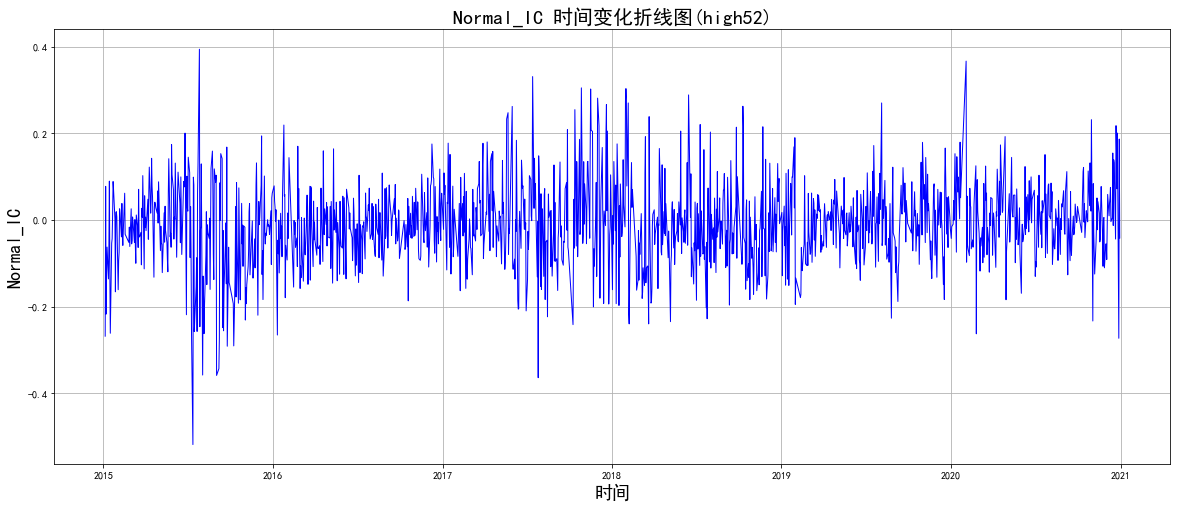

<Figure size 432x288 with 0 Axes>

In [47]:
# Normal IC 时间变化折线图

plt.figure(figsize=(20,8))
x=IC_1['trade_date']
y=IC_1['Normal_IC']
plt.plot(x,y,lw=1,c='blue',ms=4,label='Normal_IC 时间变化折线图')
plt.title('Normal_IC 时间变化折线图(high52)',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(-0.1,-0.02,0.005)
plt.xlabel('时间',fontsize=18)
plt.ylabel('Normal_IC',fontsize=18)
plt.grid()
plt.show()
plt.savefig('Normal_IC 时间变化折线图(high52).png')



In [48]:
# rank IC 排序升序
IC_2=ret_5
IC_2['fac_rank']=IC_2.groupby(['trade_date'])['std_neu_high52'].rank()
IC_3=pd.DataFrame(IC_2.groupby(['trade_date'])['fac_rank'].corr(IC_2['ret_t1'])).reset_index()
IC_3=IC_3.rename(columns={'fac_rank':'rank_IC'})


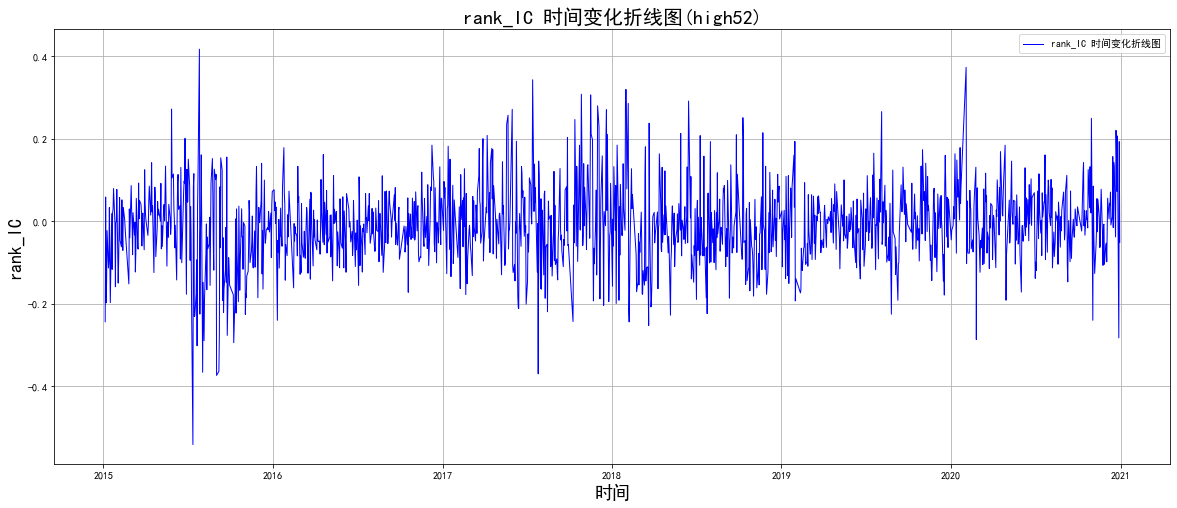

<Figure size 432x288 with 0 Axes>

In [49]:
# Normal IC 时间变化折线图

plt.figure(figsize=(20,8))
x=IC_3['trade_date']
y=IC_3['rank_IC']
plt.plot(x,y,lw=1,c='blue',ms=4,label='rank_IC 时间变化折线图')
plt.title('rank_IC 时间变化折线图(high52)',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(-0.1,-0.02,0.005)
plt.xlabel('时间',fontsize=18)
plt.ylabel('rank_IC',fontsize=18)
plt.legend()
plt.grid()
plt.show()
plt.savefig('rank_IC 时间变化折线图(high52).png')



In [50]:
IC_4=pd.DataFrame()
Normal_IC=pd.Series({"mean":IC_1['Normal_IC'].mean(),"std":IC_1['Normal_IC'].std(),"IRIC":IC_1['Normal_IC'].mean()/IC_1['Normal_IC'].std(),"skew":IC_1['Normal_IC'].skew()},name="Normal_IC")
rank_IC=pd.Series({"mean":IC_3['rank_IC'].mean(),"std":IC_3['rank_IC'].std(),"IRIC":IC_3['rank_IC'].mean()/IC_3['rank_IC'].std(),"skew":IC_3['rank_IC'].skew()},name="rank_IC")
IC_4=IC_4.append(Normal_IC)
IC_4=IC_4.append(rank_IC)


In [51]:
IC_4

,IRIC,mean,skew,std
Normal_IC,-0.115538,-0.011204,0.039804,0.096971
rank_IC,-0.110193,-0.010711,0.071718,0.097199


In [52]:
# 分层测试
Group_test=ret_5.copy()
Group_test['Group_ID']=Group_test.groupby(['trade_date'])['std_neu_high52'].transform(lambda x:pd.qcut(x,[0,0.2,0.4,0.6,0.8,1],labels=['1','2','3','4','5']))
Group_test_1=pd.DataFrame(Group_test.groupby(['trade_date','Group_ID'])['ret_t1'].mean()).reset_index().rename(columns={'ret_t1':'Group_ret_mean'})


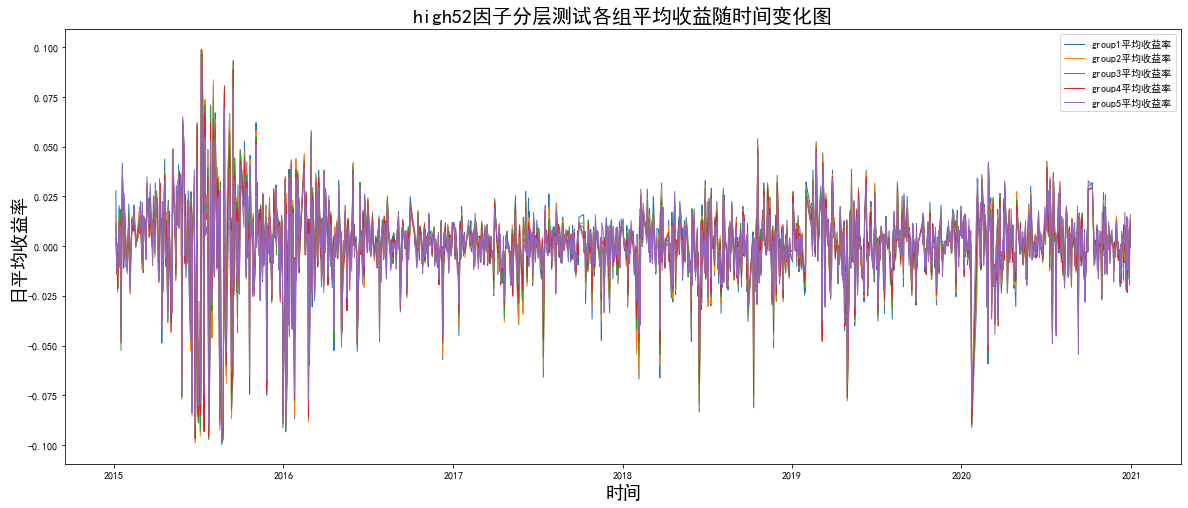

<Figure size 432x288 with 0 Axes>

In [53]:
# 因子分层测试各组日平均收益随时间变化图

x=pd.Series(np.unique(Group_test_1['trade_date']))
y1=Group_test_1[Group_test_1['Group_ID']=='1']['Group_ret_mean']
y2=Group_test_1[Group_test_1['Group_ID']=='2']['Group_ret_mean']
y3=Group_test_1[Group_test_1['Group_ID']=='3']['Group_ret_mean']
y4=Group_test_1[Group_test_1['Group_ID']=='4']['Group_ret_mean']
y5=Group_test_1[Group_test_1['Group_ID']=='5']['Group_ret_mean']

plt.figure(figsize=(20,8))
plt.plot(x,y1,lw=1,ms=4,label='group1平均收益率')
plt.plot(x,y2,lw=1,ms=4,label='group2平均收益率')
plt.plot(x,y3,lw=1,ms=4,label='group3平均收益率')
plt.plot(x,y4,lw=1,ms=4,label='group4平均收益率')
plt.plot(x,y5,lw=1,ms=4,label='group5平均收益率')
plt.title('high52因子分层测试各组平均收益随时间变化图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(-0.1,-0.02,0.005)
plt.xlabel('时间',fontsize=18)
plt.ylabel('日平均收益率',fontsize=18)
plt.legend()
# plt.grid()
plt.show()
plt.savefig('high52因子分层测试各组平均收益随时间变化图.png')

In [54]:
# 计算各组累计收益率

Group_test_1['cum_rev'] =Group_test_1.sort_values(by=['Group_ID','trade_date']).groupby(['Group_ID'])['Group_ret_mean'].apply(lambda x:(1 + x).cumprod())

In [55]:
Group_test_1.sort_values(by=['Group_ID','trade_date'])

,trade_date,Group_ID,Group_ret_mean,cum_rev
0,2015-01-05,1,0.027893,1.027893
5,2015-01-06,1,-0.004346,1.023426
10,2015-01-07,1,0.001454,1.024914
15,2015-01-08,1,-0.006211,1.018549
20,2015-01-09,1,-0.012880,1.005430
...,...,...,...,...
7289,2020-12-25,5,0.001675,0.679295
7294,2020-12-28,5,-0.019645,0.665950
7299,2020-12-29,5,0.012670,0.674388
7304,2020-12-30,5,0.013631,0.683580


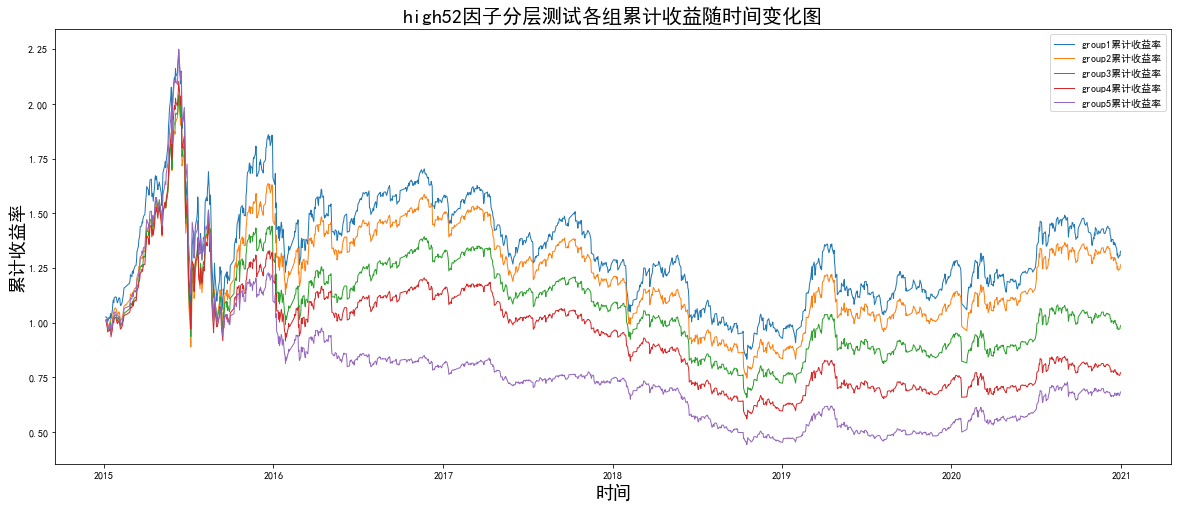

<Figure size 432x288 with 0 Axes>

In [56]:
# 因子分层测试各组累计收益随时间变化图

x=pd.Series(np.unique(Group_test_1['trade_date']))
y1=Group_test_1[Group_test_1['Group_ID']=='1']['cum_rev']
y2=Group_test_1[Group_test_1['Group_ID']=='2']['cum_rev']
y3=Group_test_1[Group_test_1['Group_ID']=='3']['cum_rev']
y4=Group_test_1[Group_test_1['Group_ID']=='4']['cum_rev']
y5=Group_test_1[Group_test_1['Group_ID']=='5']['cum_rev']

plt.figure(figsize=(20,8))
plt.plot(x,y1,lw=1,ms=4,label='group1累计收益率')
plt.plot(x,y2,lw=1,ms=4,label='group2累计收益率')
plt.plot(x,y3,lw=1,ms=4,label='group3累计收益率')
plt.plot(x,y4,lw=1,ms=4,label='group4累计收益率')
plt.plot(x,y5,lw=1,ms=4,label='group5累计收益率')
plt.title('high52因子分层测试各组累计收益随时间变化图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(-0.1,-0.02,0.005)
plt.xlabel('时间',fontsize=18)
plt.ylabel('累计收益率',fontsize=18)
plt.legend()
# plt.grid()
plt.show()
plt.savefig('high52因子分层测试各组累计收益随时间变化图.png')

In [57]:
# 计算各组年化收益率&年化波动率&夏普比率&最大回撤


Annual_1=pd.DataFrame(Group_test_1.groupby(['Group_ID'])['Group_ret_mean'].mean()).reset_index().rename(columns={'Group_ret_mean':'aver_ret'})
Annual_2=pd.DataFrame(Group_test_1.groupby(['Group_ID'])['Group_ret_mean'].var()).reset_index().rename(columns={'Group_ret_mean':'volatility'})
Annual_3=pd.merge(Annual_1,Annual_2,on=['Group_ID'])
Annual_3['Annual_aver_ret']=(1+Annual_3['aver_ret'])**252-1
Annual_3['Annual_vol']=((Annual_3['volatility'])*252)**0.5
Annual_3['Annual_Sharpe']=252*Annual_3['aver_ret']/Annual_3['Annual_vol']

arr_1=Group_test_1[Group_test_1['Group_ID']=='1']['cum_rev']
j_1 = np.argmax((np.maximum.accumulate(arr_1) - arr_1)/np.maximum.accumulate(arr_1)) # end of the period
i_1 = np.argmax(arr_1[:j_1]) # start of period
MaxDrawdown_1=(1-arr_1.iloc[j_1]/arr_1.iloc[i_1])

arr_2=Group_test_1[Group_test_1['Group_ID']=='2']['cum_rev']
j_2 = np.argmax((np.maximum.accumulate(arr_2) - arr_2)/np.maximum.accumulate(arr_2)) # end of the period
i_2 = np.argmax(arr_2[:j_2]) # start of period
MaxDrawdown_2=(1-arr_2.iloc[j_2]/arr_2.iloc[i_2])


arr_3=Group_test_1[Group_test_1['Group_ID']=='3']['cum_rev']
j_3 = np.argmax((np.maximum.accumulate(arr_3) - arr_3)/np.maximum.accumulate(arr_3)) # end of the period
i_3 = np.argmax(arr_3[:j_3]) # start of period
MaxDrawdown_3=(1-arr_3.iloc[j_3]/arr_3.iloc[i_3])


arr_4=Group_test_1[Group_test_1['Group_ID']=='4']['cum_rev']
j_4 = np.argmax((np.maximum.accumulate(arr_4) - arr_4)/np.maximum.accumulate(arr_4)) # end of the period
i_4 = np.argmax(arr_4[:j_4]) # start of period
MaxDrawdown_4=(1-arr_4.iloc[j_4]/arr_4.iloc[i_4])


arr_5=Group_test_1[Group_test_1['Group_ID']=='5']['cum_rev']
j_5 = np.argmax((np.maximum.accumulate(arr_5) - arr_5)/np.maximum.accumulate(arr_5)) # end of the period
i_5 = np.argmax(arr_5[:j_5]) # start of period
MaxDrawdown_5=(1-arr_5.iloc[j_5]/arr_5.iloc[i_5])




Annual_4=pd.DataFrame()
Annual_aver_ret=pd.Series({"Group1":float(Annual_3[Annual_3['Group_ID']=='1']['Annual_aver_ret']),"Group2":float(Annual_3[Annual_3['Group_ID']=='2']['Annual_aver_ret']),"Group3":float(Annual_3[Annual_3['Group_ID']=='3']['Annual_aver_ret']),"Group4":float(Annual_3[Annual_3['Group_ID']=='4']['Annual_aver_ret']),"Group5":float(Annual_3[Annual_3['Group_ID']=='5']['Annual_aver_ret'])},name="Annual_average_return")
Annual_vol=pd.Series({"Group1":float(Annual_3[Annual_3['Group_ID']=='1']['Annual_vol']),"Group2":float(Annual_3[Annual_3['Group_ID']=='2']['Annual_vol']),"Group3":float(Annual_3[Annual_3['Group_ID']=='3']['Annual_vol']),"Group4":float(Annual_3[Annual_3['Group_ID']=='4']['Annual_vol']),"Group5":float(Annual_3[Annual_3['Group_ID']=='3']['Annual_vol'])},name="Annual_volatility")
Annual_sharpe=pd.Series({"Group1":float(Annual_3[Annual_3['Group_ID']=='1']['Annual_Sharpe']),"Group2":float(Annual_3[Annual_3['Group_ID']=='2']['Annual_Sharpe']),"Group3":float(Annual_3[Annual_3['Group_ID']=='3']['Annual_Sharpe']),"Group4":float(Annual_3[Annual_3['Group_ID']=='4']['Annual_Sharpe']),"Group5":float(Annual_3[Annual_3['Group_ID']=='3']['Annual_Sharpe'])},name="Annual_Sharpe_Ratio")
Annual_MaxDrawdown=pd.Series({"Group1":MaxDrawdown_1,"Group2":MaxDrawdown_2,"Group3":MaxDrawdown_3,"Group4":MaxDrawdown_4,"Group5":MaxDrawdown_5},name="Annual_MaxDrawdown")


Annual_4=Annual_4.append(Annual_aver_ret)
Annual_4=Annual_4.append(Annual_vol)
Annual_4=Annual_4.append(Annual_sharpe)
Annual_4=Annual_4.append(Annual_MaxDrawdown)

In [58]:
Annual_4.T.reset_index()

,index,Annual_average_return,Annual_volatility,Annual_Sharpe_Ratio,Annual_MaxDrawdown
0,Group1,0.115055,0.344604,0.316094,0.628822
1,Group2,0.103092,0.337216,0.291018,0.632683
2,Group3,0.052864,0.325639,0.158211,0.677917
3,Group4,0.006291,0.316978,0.019784,0.733543
4,Group5,-0.018616,0.325639,0.158211,0.803092


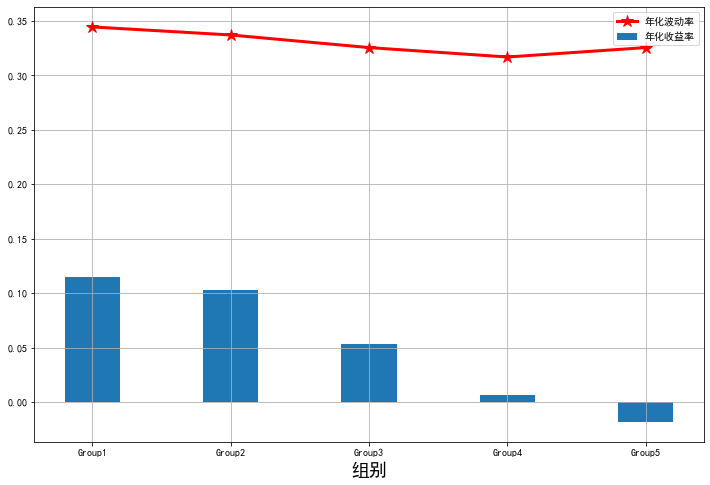

<Figure size 432x288 with 0 Axes>

In [59]:
# 年化数据组合图：年化收益&年化波动率
Annual_5=Annual_4.T.reset_index()
x=Annual_5['index']
y1=Annual_5['Annual_average_return']
y2=Annual_5['Annual_volatility']
# y3=Annual_5['Annual_Sharpe_Ratio']
# y4=Annual_5['Annual_MaxDrawdown']


plt.figure(figsize=(12,8))
plt.bar(x,y1,width=0.4,label='年化收益率')
plt.plot(x,y2,lw=3,ms=13,color='red',marker='*',label='年化波动率')
# plt.plot(x,y3,lw=3,ms=13,marker='^',label='年化夏普比')
# plt.plot(x,y4,lw=3,ms=13,marker='x',label='最大回撤率')

# for a,b in zip(x,y2):
#     plt.text(a,b,b,ha='center',va='bottom',fontsize=20)
# plt.title('年化数据组合图：年化收益&年化波动率',fontsize=20,fontweight='heavy',verticalalignment='baseline')

# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(-0.1,-0.02,0.005)
plt.xlabel('组别',fontsize=18)
# plt.ylabel('累计收益率',fontsize=18)
plt.legend()
plt.grid()
plt.show()
plt.savefig('high52年化数据组合图：年化收益&年化波动率.png')

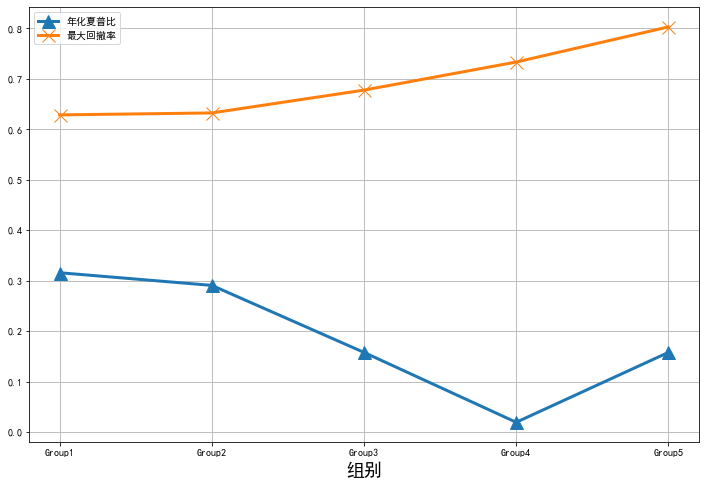

<Figure size 432x288 with 0 Axes>

In [60]:
# 年化数据组合图：最大回撤&年化夏普
Annual_5=Annual_4.T.reset_index()
x=Annual_5['index']
y3=Annual_5['Annual_Sharpe_Ratio']
y4=Annual_5['Annual_MaxDrawdown']


plt.figure(figsize=(12,8))
plt.plot(x,y3,lw=3,ms=13,marker='^',label='年化夏普比')
plt.plot(x,y4,lw=3,ms=13,marker='x',label='最大回撤率')

# for a,b in zip(x,y2):
#     plt.text(a,b,b,ha='center',va='bottom',fontsize=20)
# plt.title('年化数据组合图：年化收益&年化波动率',fontsize=20,fontweight='heavy',verticalalignment='baseline')

# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(-0.1,-0.02,0.005)
plt.xlabel('组别',fontsize=18)
# plt.ylabel('累计收益率',fontsize=18)
plt.legend()
plt.grid()
plt.show()
plt.savefig('high52年化数据组合图：最大回撤&年化夏普.png')

In [61]:
#各行业group1的年化收益

Ind_Group_test=Group_test[Group_test['Group_ID']=='1']
Ind_Group_test_1=pd.DataFrame(Ind_Group_test.groupby(['industry_name'])['ret_t1'].mean()).reset_index().rename(columns={'ret_t1':'ind_aver_ret'})
Ind_Group_test_1['Annual_ret']=(1+Ind_Group_test_1['ind_aver_ret'])**252-1

In [62]:
Ind_Group_test_1

,industry_name,ind_aver_ret,Annual_ret
0,交通运输,0.000294,0.076803
1,休闲服务,0.000363,0.095875
2,传媒,-0.000118,-0.029325
3,公用事业,-0.000059,-0.014720
4,农林牧渔,0.000496,0.133008
5,化工,0.000353,0.092935
6,医药生物,0.000295,0.077238
7,商业贸易,0.000687,0.188855
8,国防军工,0.001190,0.349485
9,家用电器,0.000309,0.080920


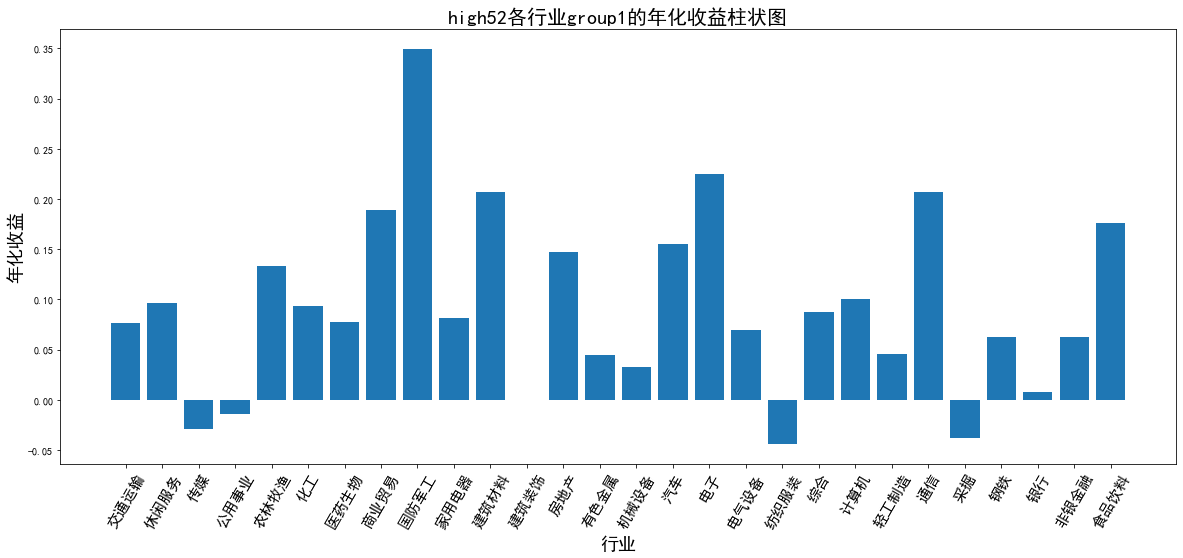

<Figure size 432x288 with 0 Axes>

In [63]:
####各行业group1的年化收益 

plt.figure(figsize=(20,8))
x=Ind_Group_test_1['industry_name']
y=Ind_Group_test_1['Annual_ret']
plt.bar(x,y)
plt.title('high52各行业group1的年化收益柱状图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(0,6,1)
plt.xlabel('行业',fontsize=18)
plt.ylabel('年化收益',fontsize=18)
# plt.grid()
plt.show()
plt.savefig('high52各行业group1的年化收益柱状图.png')

In [101]:
# 各个组别的换手率测试

Turnover_test_1=Group_test[Group_test['Group_ID']=='1']
turnover_1 = pd.DataFrame()
turnover_1['trade_date']= Turnover_test_1.trade_date.unique()
turnover_1['turnover'] = 0
    
for i in range(1,turnover_1.shape[0]):
    stock_now = set(Turnover_test_1.loc[Turnover_test_1.trade_date==turnover_1.trade_date.iloc[i],'ts_code'].tolist())
    stock_pre = set(Turnover_test_1.loc[Turnover_test_1.trade_date==turnover_1.trade_date.iloc[i - 1],'ts_code'].tolist())
    turnover_1.loc[i,'turnover'] = len(stock_pre.difference(stock_now))/len(stock_pre)       
    


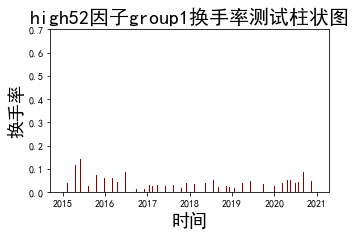

<Figure size 432x288 with 0 Axes>

In [112]:
####group1换手率测试柱状图

plt.figure(figsize=(5,3))
x=turnover_1['trade_date']
y=turnover_1['turnover']
plt.bar(x,y,color = 'darkred',width = 0.2)
plt.title('high52因子group1换手率测试柱状图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
plt.ylim(0,0.7,0.05)
plt.xlabel('时间',fontsize=18)
plt.ylabel('换手率',fontsize=18)
# plt.grid()
plt.show()
plt.savefig('high52因子group1换手率测试柱状图.png')

In [103]:
# 各个组别的换手率测试

Turnover_test_2=Group_test[Group_test['Group_ID']=='2']
turnover_2 = pd.DataFrame()
turnover_2['trade_date']= Turnover_test_2.trade_date.unique()
turnover_2['turnover'] = 0
    
for i in range(1,turnover_2.shape[0]):
    stock_now = set(Turnover_test_2.loc[Turnover_test_2.trade_date==turnover_2.trade_date.iloc[i],'ts_code'].tolist())
    stock_pre = set(Turnover_test_2.loc[Turnover_test_2.trade_date==turnover_2.trade_date.iloc[i - 1],'ts_code'].tolist())
    turnover_2.loc[i,'turnover'] = len(stock_pre.difference(stock_now))/len(stock_pre)       
    


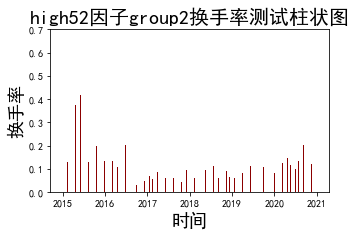

<Figure size 432x288 with 0 Axes>

In [113]:
####group2换手率测试柱状图

plt.figure(figsize=(5,3))
x=turnover_2['trade_date']
y=turnover_2['turnover']
plt.bar(x,y,color = 'darkred',width = 0.2)
plt.title('high52因子group2换手率测试柱状图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)|
# plt.yticks(y,fontsize=15)
plt.ylim(0,0.7,0.05)
plt.xlabel('时间',fontsize=18)
plt.ylabel('换手率',fontsize=18)
# plt.grid()
plt.show()
plt.savefig('high52因子group2换手率测试柱状图.png')

In [105]:
# 各个组别的换手率测试

Turnover_test_3=Group_test[Group_test['Group_ID']=='3']
turnover_3 = pd.DataFrame()
turnover_3['trade_date']= Turnover_test_3.trade_date.unique()
turnover_3['turnover'] = 0
    
for i in range(1,turnover_3.shape[0]):
    stock_now = set(Turnover_test_3.loc[Turnover_test_3.trade_date==turnover_3.trade_date.iloc[i],'ts_code'].tolist())
    stock_pre = set(Turnover_test_3.loc[Turnover_test_3.trade_date==turnover_3.trade_date.iloc[i - 1],'ts_code'].tolist())
    turnover_3.loc[i,'turnover'] = len(stock_pre.difference(stock_now))/len(stock_pre)       
    


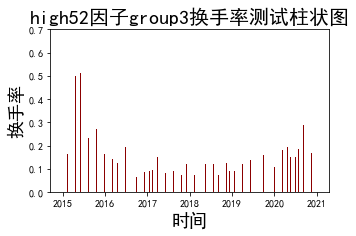

<Figure size 432x288 with 0 Axes>

In [114]:
####group3换手率测试柱状图

plt.figure(figsize=(5,3))
x=turnover_3['trade_date']
y=turnover_3['turnover']
plt.bar(x,y,color = 'darkred',width = 0.2)
plt.title('high52因子group3换手率测试柱状图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
plt.ylim(0,0.7,0.05)
plt.xlabel('时间',fontsize=18)
plt.ylabel('换手率',fontsize=18)
# plt.grid()
plt.show()
plt.savefig('high52因子group3换手率测试柱状图.png')

In [107]:
# 各个组别的换手率测试

Turnover_test_4=Group_test[Group_test['Group_ID']=='4']
turnover_4 = pd.DataFrame()
turnover_4['trade_date']= Turnover_test_4.trade_date.unique()
turnover_4['turnover'] = 0
    
for i in range(1,turnover_4.shape[0]):
    stock_now = set(Turnover_test_4.loc[Turnover_test_4.trade_date==turnover_4.trade_date.iloc[i],'ts_code'].tolist())
    stock_pre = set(Turnover_test_4.loc[Turnover_test_4.trade_date==turnover_4.trade_date.iloc[i - 1],'ts_code'].tolist())
    turnover_4.loc[i,'turnover'] = len(stock_pre.difference(stock_now))/len(stock_pre)       
    


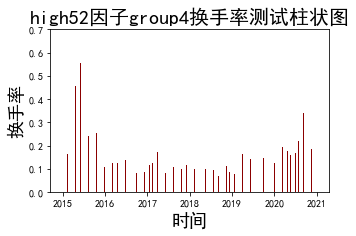

<Figure size 432x288 with 0 Axes>

In [115]:
####group4换手率测试柱状图

plt.figure(figsize=(5,3))
x=turnover_4['trade_date']
y=turnover_4['turnover']
plt.bar(x,y,color = 'darkred',width = 0.2)
plt.title('high52因子group4换手率测试柱状图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
plt.ylim(0,0.7,0.05)
plt.xlabel('时间',fontsize=18)
plt.ylabel('换手率',fontsize=18)
# plt.grid()
plt.show()
plt.savefig('high52因子group4换手率测试柱状图.png')

In [109]:
# 各个组别的换手率测试

Turnover_test_5=Group_test[Group_test['Group_ID']=='5']
turnover_5 = pd.DataFrame()
turnover_5['trade_date']= Turnover_test_5.trade_date.unique()
turnover_5['turnover'] = 0
    
for i in range(1,turnover_5.shape[0]):
    stock_now = set(Turnover_test_5.loc[Turnover_test_5.trade_date==turnover_5.trade_date.iloc[i],'ts_code'].tolist())
    stock_pre = set(Turnover_test_5.loc[Turnover_test_5.trade_date==turnover_5.trade_date.iloc[i - 1],'ts_code'].tolist())
    turnover_5.loc[i,'turnover'] = len(stock_pre.difference(stock_now))/len(stock_pre)       
    


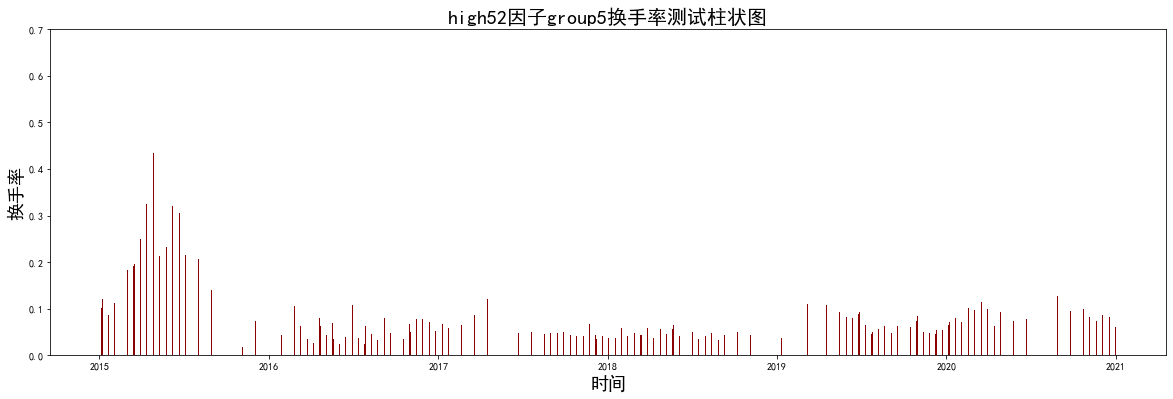

<Figure size 432x288 with 0 Axes>

In [110]:
####group5换手率测试柱状图

plt.figure(figsize=(20,6))
x=turnover_5['trade_date']
y=turnover_5['turnover']
plt.bar(x,y,color = 'darkred',width = 0.2)
plt.title('high52因子group5换手率测试柱状图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
plt.ylim(0,0.7,0.05)
plt.xlabel('时间',fontsize=18)
plt.ylabel('换手率',fontsize=18)
# plt.grid()
plt.show()
plt.savefig('high52因子group5换手率测试柱状图.png')

Dropped 2.4% entries from factor data: 2.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 2.4% entries from factor data: 2.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Returns Analysis


,1D,5D,10D,20D
Ann. alpha,-0.066,-0.086,-0.070,-0.050
beta,-0.064,-0.075,-0.067,-0.061
Mean Period Wise Return Top Quantile (bps),-2.914,-4.577,-3.854,-3.023
Mean Period Wise Return Bottom Quantile (bps),2.617,2.896,2.192,1.573
Mean Period Wise Spread (bps),-5.531,-7.515,-6.097,-4.647


<Figure size 432x288 with 0 Axes>

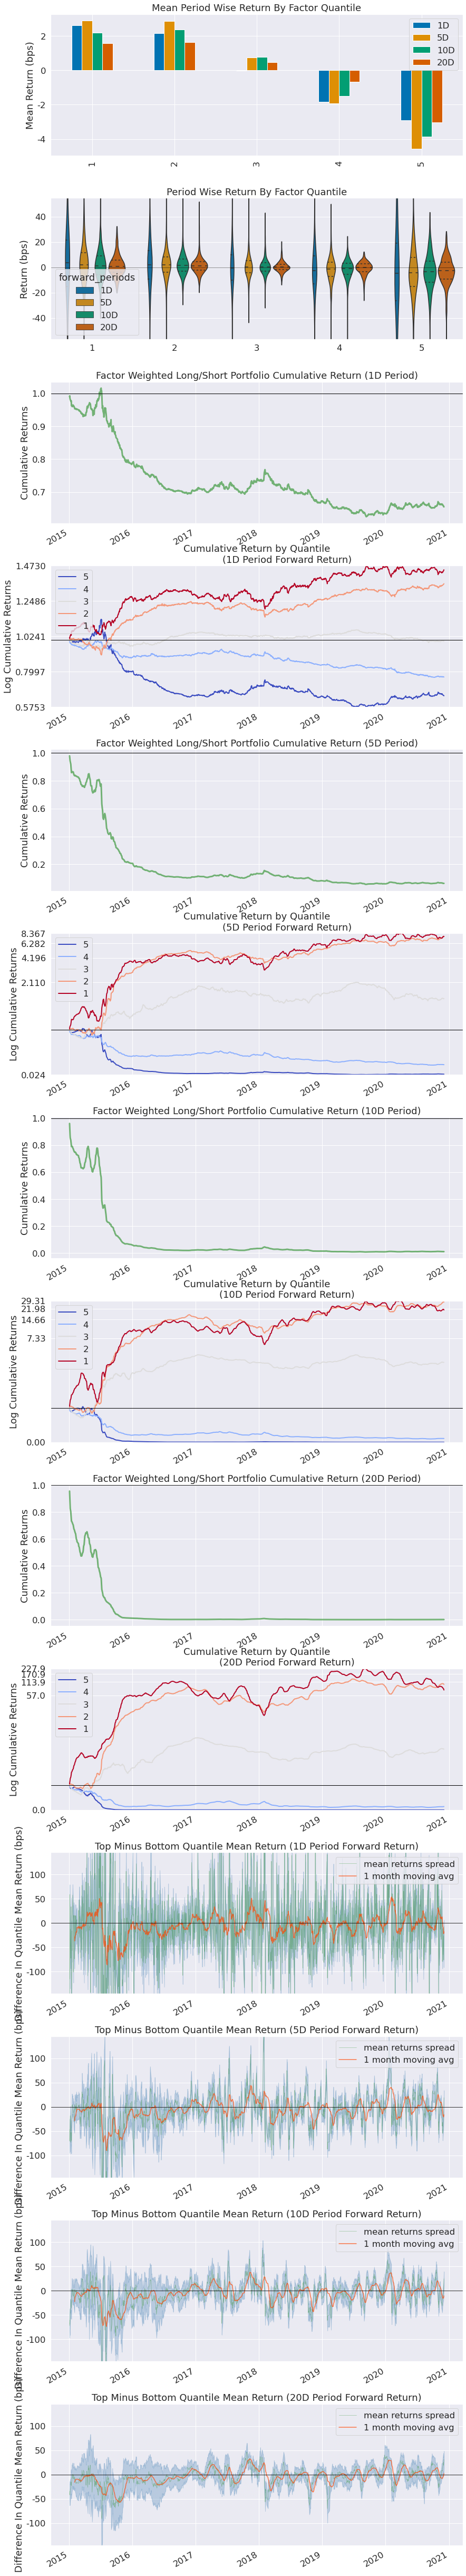

Information Analysis


,1D,5D,10D,20D
IC Mean,-0.014,-0.018,-0.019,-0.019
IC Std.,0.115,0.128,0.132,0.132
Risk-Adjusted IC,-0.119,-0.142,-0.147,-0.143
t-stat(IC),-4.516,-5.380,-5.564,-5.434
p-value(IC),0.000,0.000,0.000,0.000
IC Skew,0.135,-0.083,-0.190,-0.232
IC Kurtosis,1.109,0.753,0.493,0.320


/usr/lib/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/lib/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/lib/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplo

<Figure size 432x288 with 0 Axes>

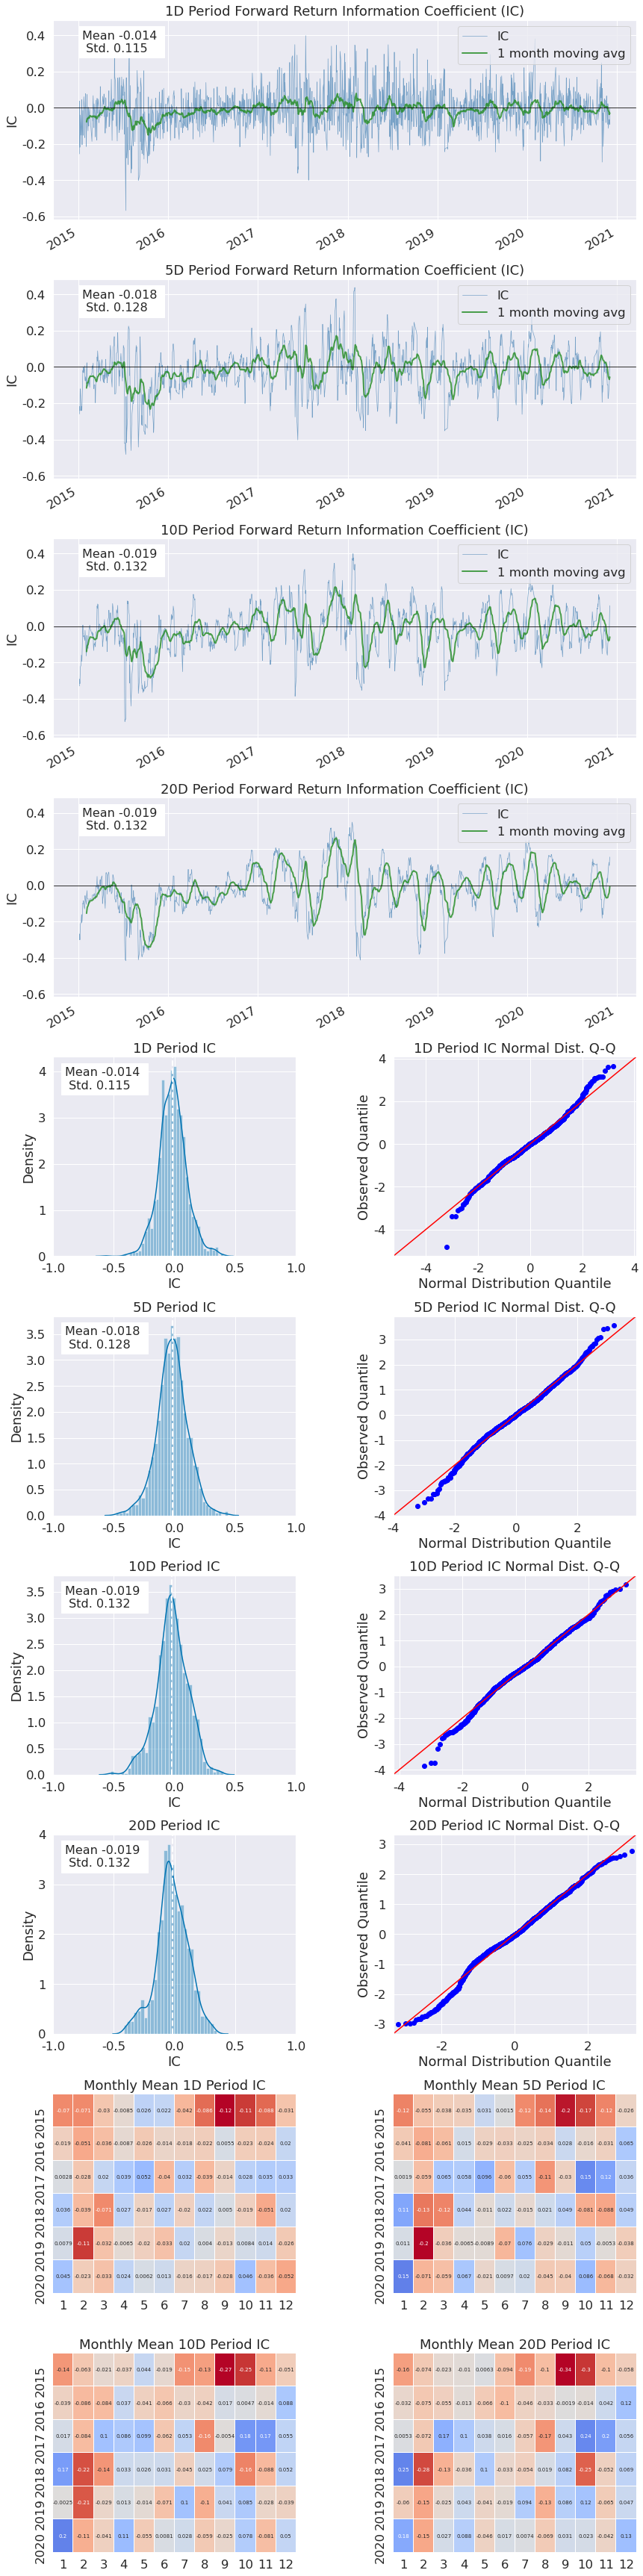

/usr/lib/miniconda3/lib/python3.8/site-packages/alphalens/utils.py:910: UserWarning: Skipping return periods that aren't exact multiples of days.
  warnings.warn(


Turnover Analysis


,1D,5D,10D,20D
Quantile 1 Mean Turnover,0.047,0.120,0.178,0.266
Quantile 2 Mean Turnover,0.118,0.259,0.350,0.464
Quantile 3 Mean Turnover,0.157,0.326,0.426,0.541
Quantile 4 Mean Turnover,0.159,0.325,0.422,0.531
Quantile 5 Mean Turnover,0.079,0.182,0.252,0.348


,1D,5D,10D,20D
Mean Factor Rank Autocorrelation,0.987,0.941,0.898,0.826


<Figure size 432x288 with 0 Axes>

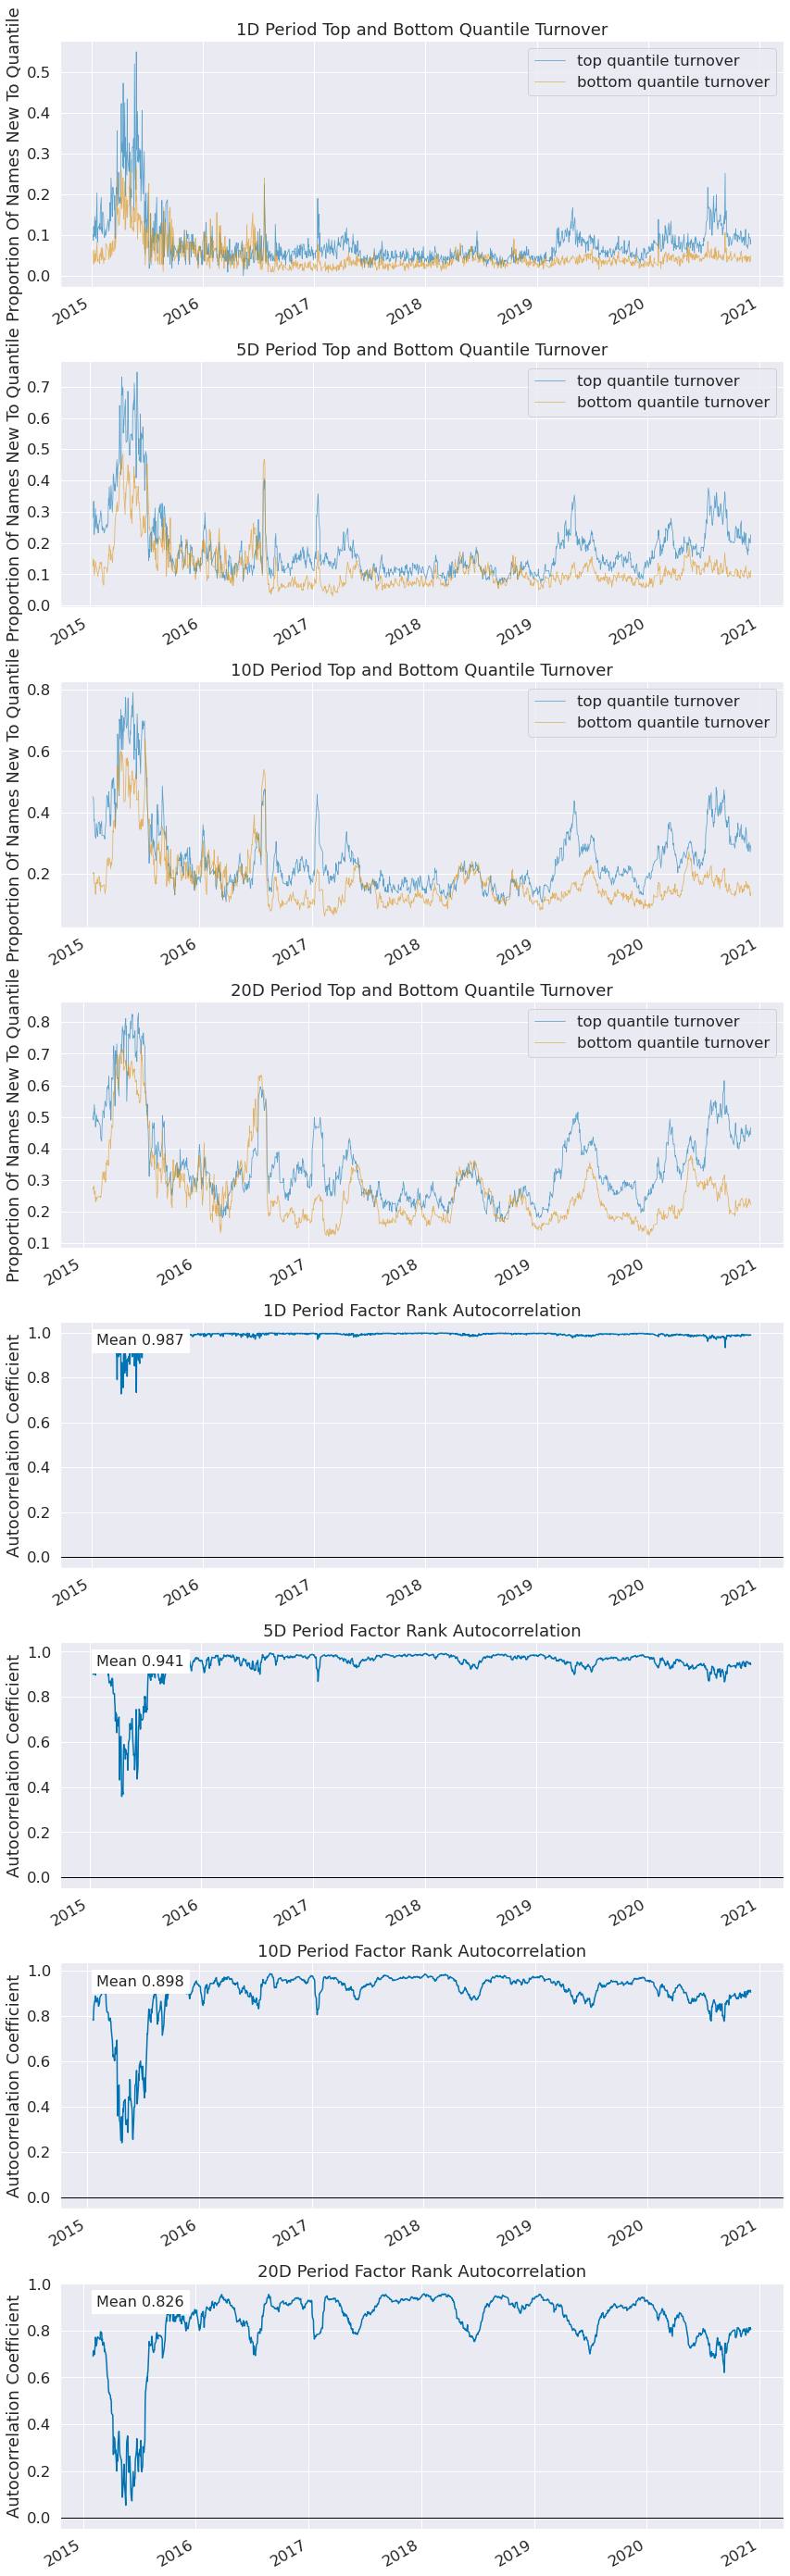

In [111]:
# Alphalens 回测结果

final=ret_5.set_index(["trade_date","ts_code"])
factor_init = final["std_neu_high52"].copy()
price_df = final["close"].unstack().copy()
factor = al.utils.get_clean_factor_and_forward_returns(factor_init, price_df,quantiles=5, bins=None,periods=(1,5,10,20),max_loss=1)


factor = al.utils.get_clean_factor_and_forward_returns(factor_init, price_df,groupby=None,binning_by_group=False,quantiles=5,bins=None,periods=(1,5,10,20),filter_zscore=20,groupby_labels=None,max_loss=1,zero_aware=False,cumulative_returns=True)
al.tears.create_returns_tear_sheet(factor)
al.tears.create_information_tear_sheet(factor, group_neutral=False,by_group=False)
al.tears.create_turnover_tear_sheet(factor, turnover_periods=None)
